# Compute density from catalog and generate density split catalogs

In [1]:
import math
import numpy as np
import scipy
from matplotlib import pyplot as plt
import matplotlib as mpl

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from cosmoprimo import *
from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging
from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, BoxSubsampler, project_to_wp, utils, setup_logging

import catalog_data
import density_split

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

## Apply RSD

In [4]:
# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
hz = bg.hubble_function(catalog.redshift)

catalog.set_rsd(hz)

### Plot halos

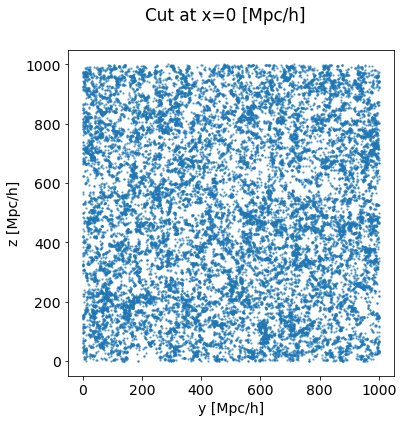

In [5]:
idx=0
cut_direction = 'x'

catalog.show_halos_map(plt.figure(figsize=(6, 6)), plt.gca(), cellsize=20, cut_direction=cut_direction, cut_idx=idx)

plt.suptitle('Cut at '+cut_direction+'={} [Mpc/h]'.format(idx*20))
plt.show()

## Compute density

In [6]:
cellsize = 20
resampler = 'ngp'

# Compute density with weights
catalog_density = density_split.DensitySplit(catalog)
catalog_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)
density_with_masses = catalog_density.data_densities

# Compute density without weights
catalog_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=False)
density_without_masses = catalog_density.data_densities

### Plot density distribution

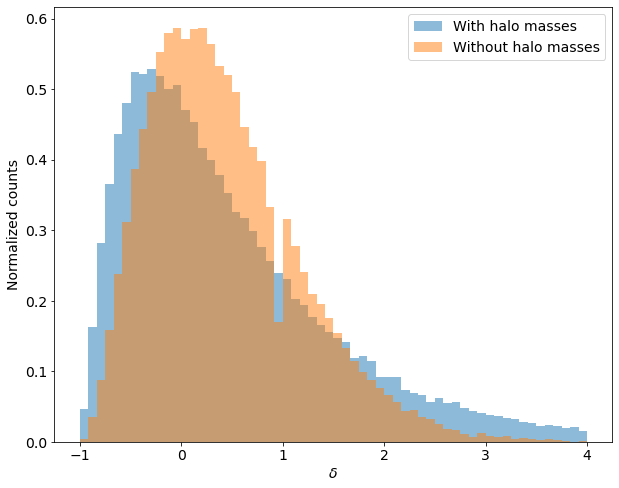

In [7]:
plt.hist(density_with_masses, range=(-1, 4), bins=60, density=True, alpha=0.5, label='With halo masses')
plt.hist(density_without_masses, range=(-1, 4), bins=60, density=True, alpha=0.5, label='Without halo masses')
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.legend()
plt.show()

### Plot density map

In [8]:
cmap = plt.get_cmap('coolwarm')

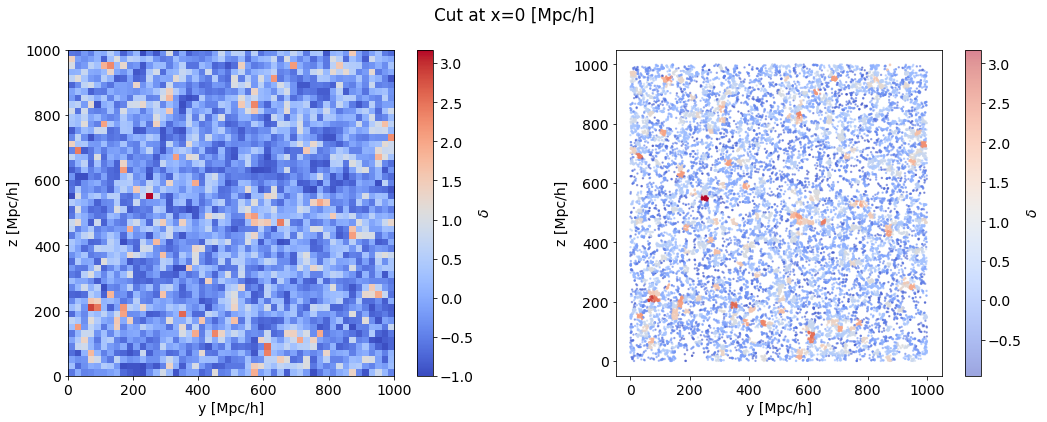

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey = False)

idx=0
cut_direction = 'x'

catalog_density.show_density_map(fig, axes[0], cut_direction=cut_direction, cut_idx=idx, cmap=cmap)
catalog_density.show_halos_map(fig, axes[1], cellsize, cut_direction=cut_direction, cut_idx=idx, cmap=cmap)

plt.suptitle('Cut at '+cut_direction+'={} [Mpc/h]'.format(idx*catalog_density.cellsize))
plt.show()

## Split density

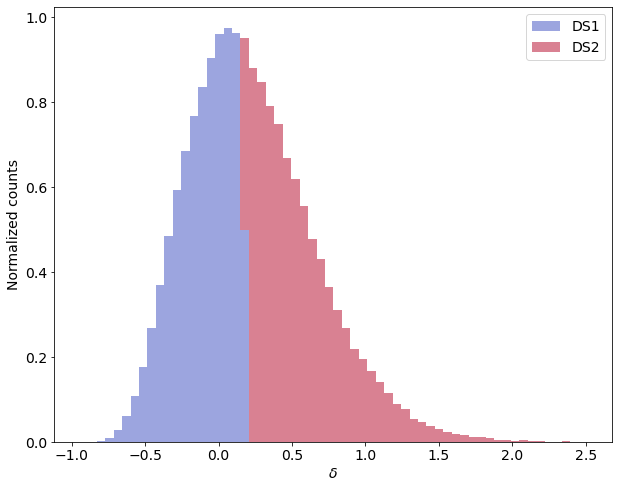

In [28]:
catalog_density.split_density(2)
cmap = plt.get_cmap('coolwarm', catalog_density.nsplits)
colors = [cmap(i) for i in range(catalog_density.nsplits)]

plt.hist(catalog_density.split_densities, bins=60, histtype='barstacked', label=['DS{}'.format(i) for i in catalog_density.split_labels], density=True,
         color=colors, alpha=0.5)
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.legend()
plt.show()

### Plot split density map

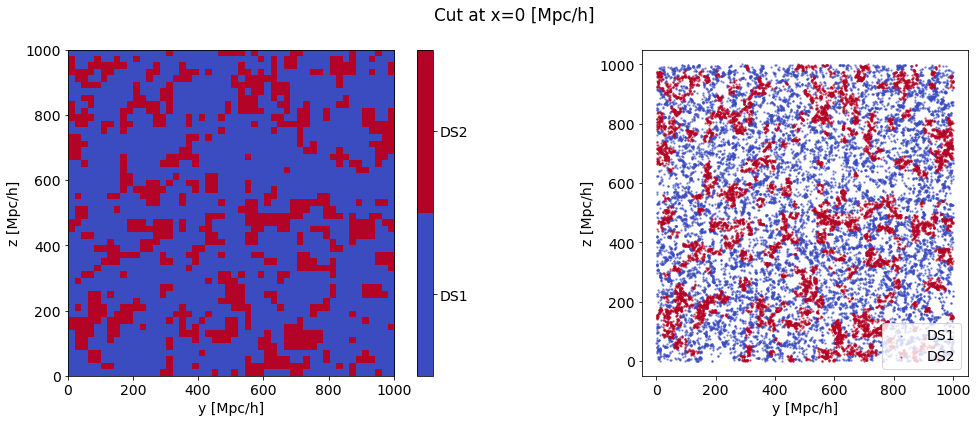

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey = False)

idx=0
cut_direction = 'x'

catalog_density.show_split_density_map(fig, axes[0], cut_direction=cut_direction, cut_idx=idx, show_halos=False, cmap=cmap)
catalog_density.show_halos_map(fig, axes[1], cellsize, cut_direction, cut_idx=idx, split=True, colors=colors)

axes[1].legend()
plt.suptitle('Cut at '+cut_direction+'={} [Mpc/h]'.format(idx*catalog_density.cellsize))
plt.show()

## Generate random catalogs in each split

In [11]:
split_samples = catalog_density.sample_splits(size=catalog.size, seed=42, update=True)

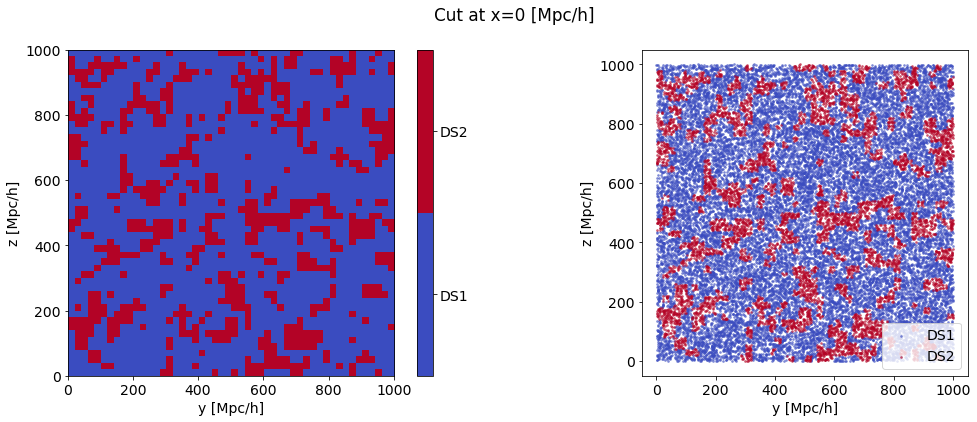

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey = False)

idx=0
cut_direction = 'x'

ax = plt.gca()
catalog_density.show_split_density_map(fig, axes[0], cut_direction=cut_direction, cut_idx=idx, cmap=cmap)
catalog_density.show_randoms_map(fig, axes[1], catalog_density.cellsize, cut_direction=cut_direction, cut_idx=idx, colors=colors)

plt.legend()
plt.suptitle('Cut at '+cut_direction+'={} [Mpc/h]'.format(idx*catalog_density.cellsize))
plt.show()

In [12]:
# Save Data instance
catalog_density.save(output_dir+catalog.name+'_density_split')